In [1]:
import numpy as np
import pandas as pd
import janitor

from functools import partial

In [2]:
wt ="SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"

In [3]:
def aa_pos(mut):
    """
    Return mutation position from mutation string.

    Example: A111C -> 111
    """
    if not mut:
        return mut
    else:
        return int(mut[2:-1])


def aa_letter(mut):
    """
    Return mutation letter from mutation string.

    Example: A111C -> C
    """
    if not mut:
        return mut
    else:
        return mut[-1]


def mut2seq(mutation_string, wt_sequence, delimiter=":"):
    """
    Reconstruct full mutant sequence given mutation string.

    Example mutation_strings:
    - A111C
    - A111T; V130A
    - A111T; Q194R; N249I; N251Y; H255Y
    """
    if mutation_string is None or mutation_string == "":
        return wt_sequence

    mutations = mutation_string.split(delimiter)
    mutant_sequence = list(wt_sequence)  # mutant_sequence is a list
    for mut in mutations:
        position = aa_pos(mut)
        letter = aa_letter(mut)
        if position == 0:
            raise ValueError(
                f"""
            The mutation string {mut} is invalid.
            It has "0" as its position.
            """
            )
        if position > len(wt_sequence):
            raise ValueError(
                f"""
            The mutation string {mut} is invalid.
            Its position is greater than the length of the WT sequence.
            """
            )
        mutant_sequence[
            position #- 1
        ] = letter  # -1 is necessary because the list is zero-indexed
    return "".join(l for l in mutant_sequence)

In [4]:
def count_mutations(x):
    if x == '':
        return 0
    else:
        return len(x.split(":"))


In [5]:
mut2gfp = partial(mut2seq, wt_sequence=wt)

## Prepare data

In [6]:
data = (pd.read_csv("data/amino_acid_genotypes_to_brightness.tsv", sep='\t')
        .fill_empty("aaMutations", "")
        .filter_string("aaMutations", search_string="\*", complement=True)
        .transform_column("aaMutations", mut2gfp, "sequence")
        .transform_column("medianBrightness", lambda x: np.log(x), "log_bright")
        .transform_column("sequence", lambda x: len(x), "length")
        .transform_column("aaMutations", count_mutations, "mutation_count")
       )

In [7]:
data.head(3)

,aaMutations,uniqueBarcodes,medianBrightness,std,sequence,log_bright,length,mutation_count
0,,3645,3.719212,0.106992,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,1.313512,237,0
1,SA108D,1,1.301030,NaN,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,0.263156,237,1
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,0.263157,237,5


In [36]:
data.query("aaMutations.str.contains(r'[A-Z]2[A-Z]')").head(1)

,aaMutations,uniqueBarcodes,medianBrightness,std,sequence,log_bright,length,mutation_count,h_avg,h_final,c_final,unirep_fusion
16351,SG2A,2,3.818888,0.119126,SKAEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,1.339959,237,1,"[0.8270660638809204, 0.19173550605773926, 10.1...","[0.005279474891722202, -0.05013052374124527, 0...","[0.0007955856272019446, 0.02143683284521103, 0...","[0.005279474891722202, -0.05013052374124527, 0..."


In [9]:
data.mutation_count.unique()

array([ 0,  1,  5,  4,  2,  6,  3,  7,  8, 11, 12, 10,  9, 13, 14, 15])

In [10]:
data.length.unique()

array([237])

## Get reps

In [11]:
from jax_unirep import get_reps

/Users/kummear1/anaconda/envs/genesis/lib/python3.7/site-packages/jax/lib/xla_bridge.py:127: UserWarning:

No GPU/TPU found, falling back to CPU.



In [12]:
h_final1, c_final1, h_avg1 = get_reps(data.sequence.values[:10000])
h_final2, c_final2, h_avg2 = get_reps(data.sequence.values[10000:20000])
h_final3, c_final3, h_avg3 = get_reps(data.sequence.values[20000:30000])
h_final4, c_final4, h_avg4 = get_reps(data.sequence.values[30000:40000])
h_final5, c_final5, h_avg5 = get_reps(data.sequence.values[40000:])

In [13]:
h_avg1.shape

(10000, 1900)

In [14]:
h_final = np.concatenate((h_final1, h_final2, h_final3, h_final4, h_final5), axis=0)
c_final = np.concatenate((c_final1, c_final2, c_final3, c_final4, c_final5), axis=0)
h_avg = np.concatenate((h_avg1, h_avg2, h_avg3, h_avg4, h_avg5), axis=0)

In [15]:
data["h_avg"] = h_avg.tolist()
data["h_final"] = h_final.tolist()
data["c_final"] = c_final.tolist()

In [16]:
def fusion(x):
    return np.concatenate((x.h_final,x.c_final, x.h_avg))

In [17]:
data = data.join_apply(fusion, "unirep_fusion")

In [18]:
data.head(3)

,aaMutations,uniqueBarcodes,medianBrightness,std,sequence,log_bright,length,mutation_count,h_avg,h_final,c_final,unirep_fusion
0,,3645,3.719212,0.106992,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,1.313512,237,0,"[0.6212358474731445, 0.10203029960393906, 10.4...","[0.0052763549610972404, -0.0479130856692791, 0...","[0.0008092823554761708, 0.013940938748419285, ...","[0.0052763549610972404, -0.0479130856692791, 0..."
1,SA108D,1,1.301030,NaN,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,0.263156,237,1,"[0.5923978090286255, 0.12201351672410965, 10.6...","[0.00533563457429409, -0.049146752804517746, 0...","[0.0006889709620736539, 0.0212150476872921, 0....","[0.00533563457429409, -0.049146752804517746, 0..."
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,0.263157,237,5,"[1.2923177480697632, 0.3601369857788086, 10.44...","[0.0052352058701217175, -0.05025510489940643, ...","[0.0010605398565530777, 0.06153016909956932, 0...","[0.0052352058701217175, -0.05025510489940643, ..."


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
sns.set_style("white")
sns.set_context(context="paper", font_scale=1.5)

In [21]:
df = pd.DataFrame.from_dict(dict(zip(data['h_avg'].index, data['h_avg'].values))).T
df['brightness'] = data["medianBrightness"].values
df.set_index(data['aaMutations'], inplace=True)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1891,1892,1893,1894,1895,1896,1897,1898,1899,brightness
aaMutations,,,,,,,,,,,,,,,,,,,,,
,0.621236,0.102030,10.404503,-9.851440,0.681565,0.803211,0.554590,-3.610229,-13.569917,-0.201451,...,1.974337,-1.937304,8.058512,-2.392447,2.331100,0.566051,1.272536,0.719894,-1.457669,3.719212
SA108D,0.592398,0.122014,10.691105,-9.943570,0.761884,0.857018,0.494300,-3.944473,-11.979290,-0.212918,...,2.032164,-1.899305,7.547936,-2.495020,2.111457,0.537725,0.898869,1.317873,-1.442424,1.301030
SA108D:SN144D:SI186V:SM231T:SL234P,1.292318,0.360137,10.445379,-9.859786,1.181589,0.620896,-0.091126,-4.014987,-10.069127,-0.030978,...,1.701076,-2.218031,8.227721,-2.382941,1.220523,-0.325793,0.217425,1.653794,-0.368597,1.301031


In [22]:
df_bnry = df.copy()
df_bnry["brightness"] = (df["brightness"] < 2.5).astype(int)

In [23]:
X, y = df_bnry.shuffle().get_features_targets(target_column_names=['brightness'])

In [24]:
print(X.shape, y.shape)

(51715, 1900) (51715, 1)


# Training and Testing

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_val_predict, KFold

### Logistic Regression on binary brightness

In [26]:
logreg = LogisticRegression()

In [27]:
# with paLogisticRegressionlel_backend("dask"):
cv = KFold(n_splits=5)
scores = cross_val_score(logreg, X, y.values.ravel(), cv=cv, scoring='accuracy')
preds = cross_val_predict(logreg, X, y.values.ravel(), cv=cv)

/Users/kummear1/anaconda/envs/genesis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/kummear1/anaconda/envs/genesis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/kummear1/anaconda/envs/genesis/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/kummear1/anaconda/envs/genesis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/kummear1/anaconda/envs/genesis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a

In [28]:
scores

array([0.89519482, 0.89461472, 0.89490477, 0.89616166, 0.89316446])

In [29]:
scores.mean()

0.8948080827612879

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
labels = [0, 1]
cm = confusion_matrix(y, preds, labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [32]:
cm

array([[0.93269518, 0.06730482],
       [0.15789717, 0.84210283]])

In [33]:
classes = ["Dark", "Bright"]

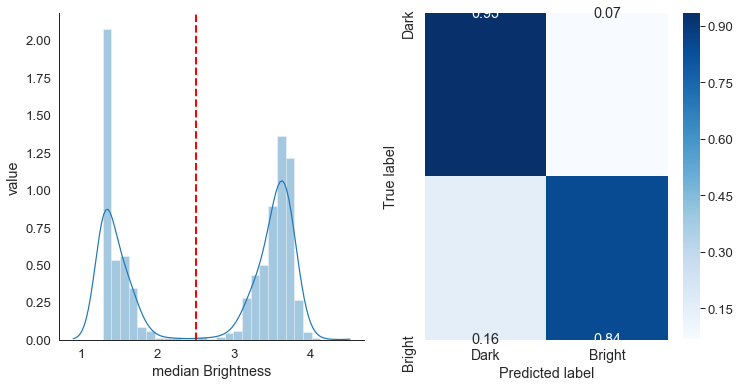

In [35]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

sns.distplot(data["medianBrightness"], ax=ax1)
ax1.axvline(x=2.5, c="r", ls="--", lw=2)
ax1.set(xlabel="median Brightness", ylabel="value")
sns.despine()

df_cm = pd.DataFrame(
    cm, index=classes, columns=classes, 
)

heatmap = sns.heatmap(df_cm, 
                      annot=True, 
                      fmt=".2f", 
                      cmap="Blues",
                      ax=ax2
                     )

ax2.set_yticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, fontsize=14)
ax2.set_xticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, fontsize=14)
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
plt.savefig("figures/top_model.png", bbox_inches='tight', dpi=200)